In [38]:

import torchvision
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

MAX_ITER = 500
EPSILON = 1e-10
TOLERANCE = 1e-5

def initializeModel(K, d):
    np.random.seed(0)
    pi = np.random.rand(K)
    pi = pi / np.sum(pi)

    np.random.seed(0)
    mu = np.random.normal(0, 3, size=(K, d))

    np.random.seed(0)
    S = np.random.rand(K, d) + 0.5

    return pi, mu, S

def GMM(X, K_RANGE):
    N, d = X.shape
    pi, mu, S = initializeModel(K_RANGE, d)
    log_r = np.zeros((N, K_RANGE))
    loss = [0.0] * MAX_ITER

    for iter in range(MAX_ITER):
        for k in range(K_RANGE):
            log_r[:,k] = np.log(pi[k]) - 0.5 * np.sum(np.log(S[k] + EPSILON)) - 0.5 * np.sum((X-mu[k]) ** 2 / (S[k] + EPSILON), axis = 1)
        
        log_r_i = logsumexp(log_r, axis = 1)
        log_r = log_r - log_r_i[:,None]
        loss[iter] = -np.sum(log_r_i)

        if iter > 1 and abs(loss[iter] - loss[iter-1]) <= TOLERANCE * abs(loss[iter]):
            break

        r = np.exp(log_r)
        r_dot_k = np.sum(r, axis = 0)
        pi = r_dot_k / N
        mu = np.matmul(r.T, X) / r_dot_k[:,None]
        S = np.matmul(r.T, X**2) / r_dot_k[:,None] - mu ** 2

    return pi, mu, S, loss

transform = transforms.Compose([transforms.ToTensor()])


[69939.41787313457, 58105.13225799935, 51670.13914384669, 41554.071199206155, 34512.117207288626, 34278.00275782545, 34245.32150643648, 34212.2427901643, 34168.29154473152, 34141.61515619645]


Text(0, 0.5, 'Negative Log Likelihood')

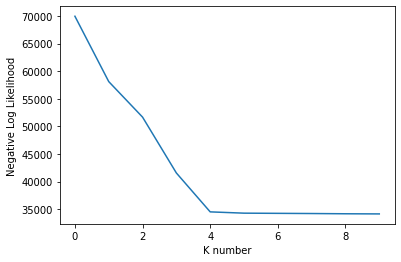

In [18]:
X = np.loadtxt(open("gmm_dataset.csv", "rb"), delimiter=",")

K = 10
pis, mus, Ss, losses = [[None for _ in range(K)] for _ in range(4)]
for k in range(10):
    pi, mu, S, loss = GMM(X, k+1)
    pis[k] = pi
    mus[k] = mu
    Ss[k] = S
    losses[k] = [ val for val in loss if val > 0.0]

final_losses = [loss[-1] for loss in losses]
plt.plot(final_losses)
plt.xlabel("K number")
plt.ylabel("Negative Log Likelihood")

In [28]:
choose_of_k = 4

print(f"Choose k to be {choose_of_k}")

models = [None] * choose_of_k
for k in range(choose_of_k):
    models[k] = (pis[choose_of_k][k], mus[choose_of_k][k], Ss[choose_of_k][k])
models.sort()
for i, model in enumerate(models):
    print(f"Model {i} with weights {model[0]}")

    print(f"Mean {model[1]}")

    print(f"Covariance {model[2]}")



Choose k to be 4
Model 0 with weights 0.09965520915997991
Mean [ 1.68895041  0.40338202  0.99211504  2.35056805  1.88562892 -0.96182475
  0.88561463 -0.19120951 -0.08586713  0.34107486  0.03539807  1.39643336
  0.73745184  0.10991832  0.42385499  0.32854659  1.46428576 -0.21035102
  0.29018548 -0.84663937]
Covariance [1.72187489 1.19321115 1.41173601 0.88740145 1.17525991 2.04880334
 0.38433712 0.67911139 1.82800002 1.53834581 1.75403135 0.88254847
 0.79972224 1.97868057 0.26419276 0.82525867 0.95488864 0.13978608
 0.55880436 0.91594801]
Model 1 with weights 0.09999844236706176
Mean [-2.56304802  0.60297421  0.90734869 -0.70992474  2.30623825 -1.43950453
  0.0635028  -0.18417534  1.51898971  1.47009916  0.13308313  0.40691041
 -0.8539717  -1.97684461 -0.32116845  0.18215543  1.2224895   1.21355931
 -0.44231741 -0.3195731 ]
Covariance [0.35688103 1.08291111 0.28247171 1.32691967 0.68869621 0.14906731
 0.40732567 1.79175932 0.76375603 0.39091032 0.64949237 0.55132451
 0.61076607 0.031462

In [43]:
K_RANGE = 10
from sklearn.decomposition import PCA
pca = PCA()
# for k in range(K_RANGE):
class_models = [None] * 10
p_y_c = [0] * 10
for identify_class in range(10):
    data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)
    TOTAL_DATA = len(data_train)
    idx = data_train.targets == identify_class
    np_X = data_train.data[idx].numpy()
    N, d1, d2 = np_X.shape
    X = np_X.reshape(N, d1*d2) / 255.0
    pi, mu, S, loss = GMM(X, 5)
    class_models[identify_class] = (pi, mu, S)
    p_y_c = N / TOTAL_DATA

LinAlgError: Last 2 dimensions of the array must be square

In [40]:
# Test
data_test = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = False,
                            download = True)
error = 0
for x, y in data_test:
    N, d1, d2 = x.shape
    x = x.reshape(N, d1*d2).numpy() / 255.0
    y_probs = np.zeros(10)
    for class_c in range(10):
        pi, mu, S = class_models[class_c]
        log_p_ik = np.log(pi) - 0.5 * np.sum(np.log(S + EPSILON), axis=1) - 0.5 * np.sum((x-mu) ** 2 / (S + EPSILON), axis = 1)
        log_p = logsumexp(log_p_ik)
        y_probs[class_c] = log_p + np.log(p_y_c)
    y_pred = np.argmax(y_probs)
    if y_pred != y:
        error += 1
print(f"Error rate {error/len(data_test)}")


Error rate 0.6752
